# "Understanding Word2Vec: Code and Math"
> "In this blog post, we'll get a better understanding of how Word2Vec works. Not only coding it from zero, but also understanding the math behind it. Let's dive in!"

- toc:true- branch: master- badges: true- comments: true
- author: Siniša Stanivuk
- categories: [fastpages, jupyter, nlp, paper, from scratch]

![](my_icons/patrick-tomasso-Oaqk7qqNh_c-unsplash.jpg "Photo by <a href="https://unsplash.com/@impatrickt?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Patrick Tomasso</a> on <a href="https://unsplash.com/s/photos/books?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Unsplash</a>")

Text, like everything else in one way or another, can be represented with math and numbers. Words can have meaning even if they aren't in the textual form us humans are accustomed to. In order to use words to solve problems computationally, researchers had to redefine that approach. And in comes Word2Vec!

Instead of representing words as boring one-hot encoded vectors using only ones and zeros, we could use Word2Vec model and represent each word by dense vectors. Each vector having multitude of features describing every word in its own way.

Instead of leaving this notebook to collect dust in some folder, I wanted to share it. What makes this blog post different than other word2vec from scratch blog posts, is that I'm fully working out the math part, so you (and I) can better understand what's going on under the hood.

## One-Hot Encoded Vectors
Even though I said that one-hot encoded vectors are boring, they are still used in Word2Vec models. That's why we'll quickly brush over the topic before moving on. OHE vectors consist only of ones and zeros. The vector is mainly consisted of zeros, except for those indexes where some word $w_c$ (corresponding to the said index) is in a window of words of the target word $w_t$. Don't bother with this definition. You'll understand better from the following example.<br><br>

Example sentence: `I like learning everything.`

Imagine a word $w_t$ was the word `I` and the window of words is equal to 2. This window is called <i>context</i>. Practically, this means we are looking two words before the word `I` and two words after it. Since `I` is the first word, we can only 'see' two words after it. In other words, we can see that the two one-hot encoded vectors corresponding to words `like` and `learning` respectively:<br><br>


I ................ [0] [0] <br>
like ........... [1] [0]<br>
learning ... [0] [1]<br>
everything [0] [0]<br><br>


Now, it's easy to grasp how inefficient this approach would be (memory-wise) if we had thousands or hundreds of thousands of words (some languages have millions) since these vectors are very sparse (they have an extremely low number of non-zero values).<br><br>
That's where researchers stepped in and revolutionized word representation with the Word2Vec model. Word2Vec has two types of models:
- Continuous Bag of Words model (CBOW)
- Skip-gram model
<br><br>
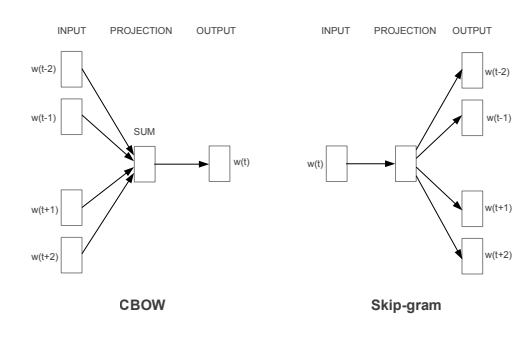
<br>

CBOW model is built to predict some target word $w_t$ given words in target word's window, denoted by $w_c$. For example, given words `I have __ every day.`, the model might predict words like `work` or `classes`.<br>

Skip-gram on the other hand is the exact opposite of the CBOW model. Skip-gram uses the target word $w_t$ to predict the words in its context, or $w_c$. For example, given word `guitar`, the model might predict words like `electric`, `play`, `acoustic`, or `bass`.<br>
The actual word representations come from matrices used in these models. Since there exist two of them, we can just take the mean of elements at the same positions and get one matrix. One of the parameters we can set up is the dimension of the final matrix. Its dimensions will be $V\times d$, where $V$ is the number of unique words in our text, or rather the size of the <i>vocabulary</i>, and parameter $d$ represents the dimension of the vector for each word $w_i$.


## Utility Functions


Before we begin with the actual word2vec model, we'll create some utility functions for tokenization, creating one-hot encoded (or OHE for short) vectors, and so on...

In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
%matplotlib inline

The first utility function we're going to cover is  the`tokenize` function. This function receives some text and extracts all words from it into a list. By using <i>regular expressions</i>, we can create a pattern, which will return an array of all words from the text. 

> Note: that bellow provided regular expression finds only words, not numbers, and also takes words like `let's` and `I'm` as one word instead of two.

In [2]:
def tokenize(text):

  pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')

  return pattern.findall(text.lower())

`mapping` function creates a vocabulary of unique words and pairs them with numbers for easier manipulation. That's why we're using dictionaries mapping words to numbers, but also numbers to words. Since we can't get keys by the values of a dictionary, we'll need both dictionaries in the future.

In [3]:
def mapping(text_array):

  idx_to_word = {}
  word_to_idx = {}

  i=0; j=0
  for idx, word in enumerate(text_array):
    if word not in idx_to_word.values():
      idx_to_word[i] = word
      i+=1
      
    
    if word not in word_to_idx.keys():
      word_to_idx[word] = j
      j+=1
      

  return idx_to_word, word_to_idx

Lastly comes the function for creating OHE vectors. We need to provide tokenized text, dictionary of words to numbers and window size, or rather the context size.<br>
Given those, the output will be an array of pairs of OHE vectors. One pair is consisting of OHE vector for $w_t$ (center word), and OHE vectors for $w_c$, one OHE vector for every word in $w_t$'s context.

In [4]:
def one_hot_encoding(text_array, word_to_idx, window_size):

  matrix = []

  for idx, word in enumerate(text_array):
    
    center_vec = [0 for w in word_to_idx]
    center_vec[word_to_idx[word]] = 1


    context_vec = []
    for i in range(-window_size, window_size+1):
      
      if i == 0 or idx+i < 0 or idx+i >= len(text_array) or word == text_array[idx+i]:
        continue
      
      temp = [0 for w in word_to_idx]
      temp[word_to_idx[text_array[idx+i]]] = 1 

      context_vec.append(temp)
      
    matrix.append([center_vec, context_vec])
    

  return matrix

## Training

Since the actual final output of forward pass is the softmax function applied to vector $u$, we'll first define the softmax function as:
$$ \frac{exp(u_j)}{\sum_{j'=1}^V exp(u_{j'})}, \ for \ each\ u_j \ in \ u$$
By using the softmax function, we transform plain numbers of our output vector $u$ into some probability distribution $p$. That way, we can easily extract words with the highest probabilities of being in a context for $w_t$.

In [5]:
def softmax(u):
  return [np.exp(u_j) / np.sum(np.exp(u)) for u_j in u]

The forward pass is very simple. It's comprised of a couple of matrix multiplications and softmax function at the end.<br><br>
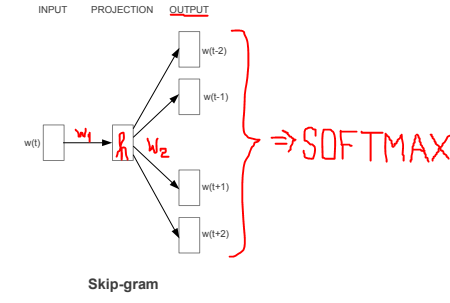

Above is an annotated picture from the paper, so we can better grasp the locations of each variable and why each equation is the way it is.

We can imagine word $w_t$ passing through our model and through following equations:<br>
$$ h = w_t^{T} \times w_1$$
$$ u = h \times w_2$$
and finally:
$$ y = \mathcal {S}oftmax(u) $$

In [6]:
def forward_pass(wt, w1, w2):

  wt = np.array(wt)

  h = np.dot(wt.T, w1)

  u = np.dot(h, w2)
  
  return softmax(u), h, u

Let's now work our way through the loss function so we can create a function which calculates it: $$ L = -logP(w_1,..., w_C|w_t) = -log{\displaystyle \prod_{c=1}^{C} \frac{exp(u_{c,j^*_c})}{\sum_{j'=1}^V exp(u_{j'})}} = - \sum_{c=1}^C log \frac{exp(u_{j^*_c})}{\sum_{j'=1}^V exp(u_{j'})} = \\-\sum_{c=1}^C(u_{j^*_c} - log \sum_{j'=1}^V exp(u_{j'})) = \\ - \sum_{c=1}^C u_{j^*_c} + \sum_{c=1}^C (log \sum_{j'=1}^V exp(u_{j'})) = \\ - \sum_{c=1}^C u_{j^*_c} + C log \sum_{j'=1}^V exp(u_{j'})$$ <br>
The loss function is calculated for every word and after each epoch. $C$ denotes the number of <i>context</i> words for some particular target word. Vector $u$ denotes the output of the forward pass, before the softmax function is applied, which further indicates that $u_{j^*_c}$ is a concrete number in that vector corresponding to the $c$-th context word. <br>
Bellow, you can have a look at how we calculate the loss function:

In [7]:
def loss(w_c, u):
  return -np.sum([u[word.index(1)] for word in w_c]) + len(w_c) * np.log(np.sum(np.exp(u)))

We are taking `u[word.index(1)]` because our vector `word` is a one-hot encoded vector, that is, we're taking the index of that OHE vector where its value is equal to 1 (that gives us the $j_c^*$-th index).

Before we jump to backpropagation, we need to calculate the error the model makes. But why, and how do we do that? 

We calculate the error because the error propagates back through the model and that's ultimately how the model learns. When it comes to "how", we derive the loss function with respect to every word in the context.

> Note: We aren't deriving $L = -logP(w_1,..., w_C|w_t)$ but rather loss for one specific word, or rather $L = -logP(w_c|w_t)$ like follows:


$$ \frac{\partial L}{\partial u_{c,j}} = \frac{\partial}{\partial u_{c,j}} (-  u_{j_c}) + \frac{\partial}{\partial u_{c,j}} log\sum_{j'=1}^V exp(u_{j'}) = \\ -t_{c,j} + \frac{1}{\sum_{j'=1}^V exp(u_{j'})} \frac{\partial}{\partial u_{c,j}} (\sum_{j'=1}^V exp(u_{j'})) = \\ - t_{c,j} + \frac{1}{\sum_{j'=1}^V exp(u_{j'})}(0 + 0 + ...+ \frac{\partial}{\partial u_{c,j}} exp(u_{c, j}) + ... + 0) = \\
\frac{exp(u_{c,j})}{\sum_{j'=1}^V exp(u_{j'})} - t_{c,j} = y_{c,j} - t_{c,j}$$

$t_{c,j}$ is OHE vector that represents some word $c$ which has value 1 at $j$-th index; $y_{c,j}$ is $j$-th value of a softmax output of the model for a word $c$.
You can look at this as the difference between the model's output and the expected output. 

Now, we sum those errors and calculate the error like so:

In [8]:
def error(out, w_c):
  out = np.array(out) 
  w_c = np.array(w_c)

  return np.sum([np.subtract(out, w) for w in w_c], axis=0)

Now that we calculated the error, we need to propagate it back through the model. 

Firstly, we calculate the update for $w_2$ matrix:
$$ \frac{\partial L}{\partial w_2} = \sum_{c=1}^C \frac{\partial L}{\partial u_{c,j}} \frac{\partial u_{c,j}}{\partial w_2} = E \cdot h = dw_2$$
This is because $u = h \times w_2$ and we already calculated the error from $\frac{\partial L}{\partial u_{c,j}}$.

Before we proceed to the update for $w_1$ matrix, we need to calculate the following derivative (which is similar to the previous equation):
$$ \frac{\partial L}{\partial h} = \sum_{j=1}^V \frac{\partial L}{\partial u_{c,j}} \frac{\partial u_{c.j}}{\partial h} = E \cdot w_2 = EH$$

Now, we can calculate $dw_1$:
$$ \frac{\partial L}{\partial w_1} = \frac{\partial L}{\partial h} \frac{\partial h}{\partial w_1} = EH \cdot w_t = dw_1$$
This is because $h = w_t^T \times w_1$.



In [9]:
def backprop(out, word, w1, w2, h):
  err = error(out, word[1]).T

  dw2 = np.outer(err, h)
  EH = np.dot(err, w2.T)
  dw1 = np.outer(EH, np.array(word[0]).T)

  return dw1.T, dw2.T

The actual part where the model learns to update its weights is defined in the following equation. Mathematically, this is done as:
$$ w_1^{new} = w_1^{old} - l_r \nabla w_1$$
and same for the second set of weights:
$$ w_2^{new} = w_2^{old} - l_r \nabla w_2$$

$\nabla$ (nabla) sign is just a sign for gradient which is why this learning process is called <i>gradient descent</i>. 

In our code, we can use $dw_i$ instead of $\nabla w_i$, since they're one in the same.


In [10]:
def learning(w1, w2, dw1, dw2, lr):
  w1 = np.subtract(w1, np.multiply(lr, dw1))
  w2 = np.subtract(w2, np.multiply(lr, dw2))

  return w1, w2

Now, in the `train` method, we collect everything previously done into one function. We initialize weights with random uniform distribution ${\mathcal {U}}(-1, 1)$. Since these numbers may be too large, we multiply them with 0.01.

In every epoch, for every word, we perform forward pass, backpropagation, and then update weights and calculate the loss. `history` is set up as a way to monitor (and later plot) losses as the model goes through each epoch. This is mainly done to check if the model is learning something or not.

In [11]:
def train(words, vocab, lr, epochs, dim):

  w1 = np.random.uniform(-1, 1, (len(vocab), dim)) * 0.01
  w2 = np.random.uniform(-1, 1, (dim, len(vocab))) * 0.01

  history = {}
  for e in range(epochs):

    l = 0

    for word in words:
      out, h, u = forward_pass(word[0], w1, w2)
      dw1, dw2 = backprop(out, word, w1, w2, h)
      w1, w2 = learning(w1, w2, dw1, dw2, lr)

      l += loss(word[1], u)
    
    if e % 100 == 0:
      history[e] = l
  
  return w1, w2, history

## Predicting

Predicting is nothing more than a forward pass through the model for some target word and then returning the most likely ones to be in its context. 

> Note: We can't provide a word the model wasn't trained on, no matter how similar or synonymous the word is to those words we did train our model on.

In [12]:
def predict(word, w1, w2, matrix, words, indices):
  out, _, _ = forward_pass(matrix[words[word]][0], w1, w2)

  most_likely_idxs = np.array(out).argsort()[-4:][::-1]
  return [indices[w] for w in most_likely_idxs]

## Going into practice

Let's test our Word2Vec model and see how everything works. We'll take a random sentence as an example to train the model on.

All this is done in couple of steps:
1. Tokenize the text
2. Map tokens to numbers
3. Create appropriate OHE vectors
4. Train the model

In [19]:
text = 'I like studying machine learning on Tuesdays at 8 o\'clock, just after drinking tea with honey.'

tokens = tokenize(text)
idxs, words = mapping(tokens)
mat = one_hot_encoding(tokens, words, window_size=2)

w1, w2, history = train(mat, words, lr=0.01, epochs=1000, dim=5)

We'll plot the loss function over epochs during training to see if the model learned got better over time at predicting the context words given the target words.

Text(0, 0.5, 'Loss')

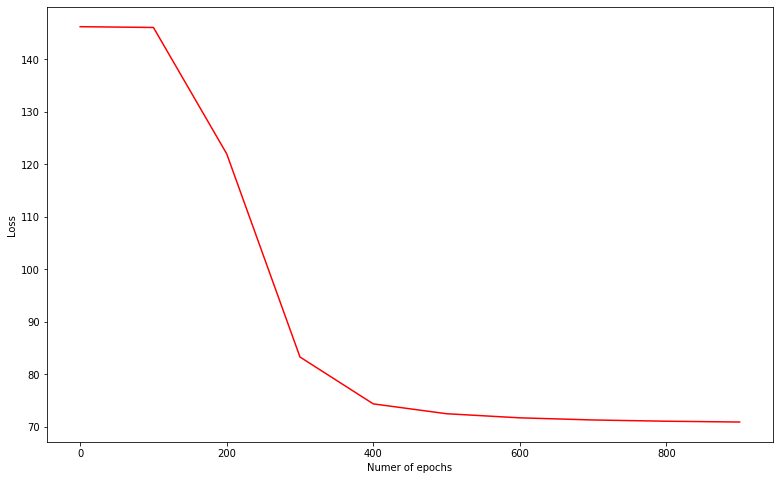

In [14]:
plt.figure(figsize=(13, 8))
plt.plot(list(history.keys()), list(history.values()), color='red')
plt.xlabel('Numer of epochs')
plt.ylabel('Loss')

And it did! The loss was reducing at rapid speed, and then plateaued (or reached the point of no big changes in learning).

We can also have a look at our embeddings, or word representations, which may be the main result of this lesson:

In [15]:
#hide_input
np.round(np.mean([w1, w2.T], axis=0), 6)

array([[-0.760096,  1.081376, -0.035396, -1.566136, -1.110661],
       [-0.791187,  1.24666 ,  0.165662, -1.512071, -1.193707],
       [-0.900263,  1.52273 ,  0.423059, -1.069264, -1.184348],
       [-0.780668,  1.734378,  0.901128,  0.016134, -0.940961],
       [-0.60948 ,  1.643683,  1.027827,  0.838088, -0.56785 ],
       [-0.219296,  1.418413,  1.02701 ,  1.525386, -0.173196],
       [ 0.248103,  0.912202,  0.838519,  1.871451,  0.368898],
       [ 0.731824,  0.289791,  0.485407,  1.95012 ,  0.740083],
       [ 1.061514, -0.376166,  0.219472,  1.659817,  1.058578],
       [ 1.226131, -1.05333 , -0.240575,  1.193058,  1.128762],
       [ 1.094737, -1.637823, -0.55898 ,  0.4753  ,  1.112364],
       [ 0.691262, -1.784794, -0.879762, -0.167793,  0.818602],
       [ 0.018381, -1.801503, -1.140091, -1.075799,  0.421966],
       [-0.322574, -1.544497, -1.143929, -1.395612,  0.135216],
       [-0.462052, -1.304585, -1.043356, -1.456119,  0.021236]])

The prediction part of the model shouldn't be forgotten either. If we predict context words of the word `drinking` for example, we'll get the following most likely context words:

> Note: Example sentence was: `'I like studying machine learning on Tuesdays at 8 o'clock, just after drinking tea with honey.'`</i>

In [16]:
predict('drinking', w1, w2, mat, words, idxs)

['with', 'just', 'tea', 'after']

# Conclusion

Working with words was inefficient and slow. One-hot encoded vectors were an easy and quick solution but included no intuitiveness or creativity. Until Word2Vec appeared as a seemingly simple solution which was its own revolution. It changed how we observe, process, and work with words and texts in general. <br><br>

***
<br>

Thank you for reading up to here!<br>
This was mainly made as a reminder and a practice for me, but if this helped you, feel free to share or comment to let me know your thoughts!

If you find any mistakes I made, notify me and I'll make the necessary changes and mention you and your help. Any and all suggestions and constructive criticism are always welcome. We're all here to learn!


# References And Further Literature



[1]   <a href="https://arxiv.org/pdf/1301.3781.pdf"> T. Mikolov, K. Chen, G. Corrado, and J. Dean. Efficient estimation of word representations
in vector space. ICLR Workshop, 2013.</a><br>
[2]   <a href="https://arxiv.org/pdf/1310.4546.pdf">T. Mikolov, I. Sutskever, K. Chen, G. Corrado, and J. Dean. Distributed Representations of
Words and Phrases and their Compositionality. Accepted to NIPS 2013.</a><br>
[3] <a href='https://arxiv.org/pdf/1411.2738.pdf'>X. Rong. word2vec Parameter Learning Explained. ArXiv 2014.</a>

